In [1]:
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from bs4 import BeautifulSoup
from bs4.element import Comment
import re
from langdetect import detect_langs

from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
df = pd.read_csv(os.path.join('..', '..', 'data', 'yelp_data', 'updated', 'bussiness_with_corpus.csv'))
df.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,is_eng,webpage_corpus
0,0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,...,0,0,0,0,1,0,0,0,True,Shooting Ranges Gun Rental Charlotte NC The Ra...
1,1,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,...,0,0,0,0,0,0,0,1,False,NaN
2,2,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,...,0,0,0,0,0,0,1,0,True,Home Renovations and Repairs Phoenix AZ Home U...
3,3,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,...,0,0,0,0,0,0,1,0,True,Home Oasis Auto CenterOasis Auto Center Pages ...
4,4,ScYkbYNkDgCneBrD9vqhCQ,Junction Tire & Auto Service,6910 E Southern Ave,Mesa,AZ,85209,33.393885,-111.682226,5.0,...,0,0,0,0,0,0,0,1,True,Contact Junction Tire Tires Auto Repair Shop i...


In [3]:
df.columns

Index(['Unnamed: 0', 'business_id', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars', 'review_count',
       'is_open', 'attributes', 'categories', 'hours', 'url', 'webpage_text',
       '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0', 'is_eng',
       'webpage_corpus'],
      dtype='object')

In [4]:
df = df[df['categories'].notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55963 entries, 0 to 56064
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      55963 non-null  int64  
 1   business_id     55963 non-null  object 
 2   name            55963 non-null  object 
 3   address         53592 non-null  object 
 4   city            55963 non-null  object 
 5   state           55963 non-null  object 
 6   postal_code     55854 non-null  object 
 7   latitude        55963 non-null  float64
 8   longitude       55963 non-null  float64
 9   stars           55963 non-null  float64
 10  review_count    55963 non-null  int64  
 11  is_open         55963 non-null  int64  
 12  attributes      48188 non-null  object 
 13  categories      55963 non-null  object 
 14  hours           45045 non-null  object 
 15  url             55963 non-null  object 
 16  webpage_text    50380 non-null  object 
 17  1.0             55963 non-null 

In [5]:
df['categories'] = df['categories'].apply(lambda x: re.split('[,;&]', x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  from ipykernel import kernelapp as app


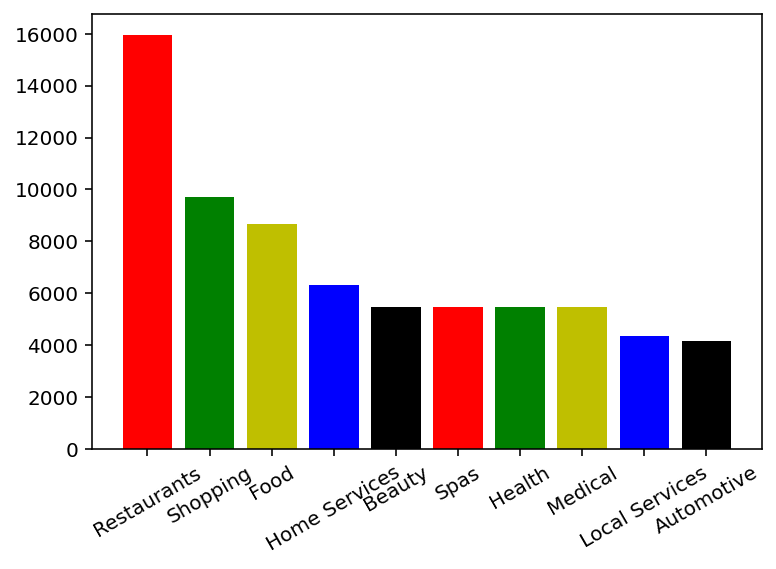

In [6]:
Categories={}

for x in df.categories:
    for cls in x:
        cls = cls.strip()
        if len(cls) < 2: continue
        if cls not in Categories: Categories[cls]=1
        else: Categories[cls]+=1

All_categories=list(Categories.keys())
classes=[[x,Categories[x]] for x in All_categories]
classes=sorted(classes, key=lambda x: x[1], reverse=True)
all_classes = classes
classes=classes[:10]
plt.bar(range(len(classes)),[x[1] for x in classes] ,align='center', color='rgybk')
plt.xticks(range(len(classes)), [x[0] for x in classes], rotation=30);

In [7]:
all_classes=sorted(all_classes, key=lambda x: x[1], reverse=True)
print(all_classes)

[['Restaurants', 15961], ['Shopping', 9697], ['Food', 8674], ['Home Services', 6332], ['Beauty', 5470], ['Spas', 5470], ['Health', 5467], ['Medical', 5467], ['Local Services', 4355], ['Automotive', 4162], ['Nightlife', 3610], ['Event Planning', 3572], ['Services', 3308], ['Bars', 3131], ['Active Life', 2920], ['Hotels', 2589], ['Arts', 2396], ['Fashion', 2337], ['Coffee', 2292], ['Home', 2282], ['Tea', 2279], ['Fast Food', 2246], ['Garden', 2142], ['Sandwiches', 2097], ['Hair Salons', 1978], ['Professional Services', 1927], ['American (Traditional)', 1915], ['Pizza', 1908], ['Auto Repair', 1907], ['Doctors', 1907], ['Real Estate', 1858], ['Entertainment', 1857], ['Travel', 1820], ['Burgers', 1643], ['Breakfast', 1619], ['Brunch', 1553], ['Fitness', 1410], ['Instruction', 1410], ['Specialty Food', 1373], ['Nail Salons', 1367], ['American (New)', 1336], ['Mexican', 1317], ['Italian', 1316], ['Pets', 1262], ['Hair Removal', 1221], ['Dentists', 1104], ['Chinese', 1098], ['Bakeries', 1085],

In [8]:
map_classes = {
                'Restaurants': 'Food', 'Food': 'Food', 'Frozen Yogurt': 'Food', 'Pizza': 'Food', 'Bars': 'Food', 'Coffee': 'Food',
                'Cafes': 'Food', 'Fast Food': 'Food', 'Bakeries': 'Food', 'Tea' : 'Food', 'Breakfast': 'Food',
                'Wine': 'Food', 'Sandwiches': 'Food', 'Burgers': 'Food', 'Brunch': 'Food', 'Breakfast': 'Food', 'Desserts': 'Food',
                'Vegetarian': 'Food', 'Vegan': 'Food', 

                'Health': 'Health', 'Dentists': 'Health', 'Doctors': 'Health', 'Medical Centers': 'Health', 'Drugstores': 'Health',
                'Local Services': 'Health', 

                'Local Services': 'Local Services', 'Car Dealers': 'Local Services', 'Professional Services': 'Local Services', 
                'Home Services': 'Local Services','Garden': 'Local Services', 'Real Estate': 'Local Services',
                'Auto Repair': 'Local Services', 'Pet Services': 'Local Services', 'Home Cleaning': 'Local Services', 
                'Public Services': 'Local Services', 'Home Decor': 'Local Services', 
                'Automotive': 'Local Services', 'Pets': 'Local Services',
    
                'Hair Salons': 'Salons', 'Nail Salons': 'Salons', 'Beauty': 'Salons', 'Hair Salons': 'Salons', 'Makeup Artists': 'Salons',
                'Hair Removal': 'Salons', 'Massage': 'Salons', 'Barbers': 'Salons', 'Beauty Supply': 'Salons',
                
                'Entertainment': 'Entertainment', 'Event Planning': 'Entertainment', 'Golf': 'Entertainment',
                'Active Life': 'Entertainment', 'Nightlife': 'Entertainment',

                'Hotels': 'Travel', 'Travel': 'Travel',
    
                'Jewelry': 'Shopping', 'Shopping': 'Shopping', 'Hobby Shops': 'Shopping', 

                'Fitness': 'Fitness', 'Sporting Goods': 'Fitness', 'Gyms': 'Fitness', 'Sports Bars': 'Fitness', 
    
                'Churches': 'Religious','Religious Organizations': 'Religious',
    
                'Education': 'Education',
    
                'Banks': 'Financial Services', 'Financial Services': 'Financial Services',
    
                'Mass Media': 'Media'
        }

In [9]:
cat = {}
bad = []
for x in df.categories:
    flg = False
    for cls in x:
        cls = cls.strip()
        if not cls in map_classes: continue
        flg = True
        mapped_cls = map_classes[cls]
        if mapped_cls not in cat: cat[mapped_cls]=1
        else: cat[mapped_cls]+=1
    if flg is False:
        bad.append(x)
        
print(len(bad))
bad[:100]

24


[['Local Flavor'],
 ['Local Flavor'],
 ['Local Flavor', ' Yelp Events'],
 ['Yelp Events', ' Local Flavor'],
 ['Yelp Events', ' Local Flavor'],
 ['Local Flavor'],
 ['Yelp Events', ' Local Flavor'],
 ['Local Flavor'],
 ['Local Flavor', ' Yelp Events'],
 ['Local Flavor', ' Yelp Events'],
 ['Local Flavor', ' Yelp Events'],
 ['Local Flavor'],
 ['Local Flavor', ' Yelp Events'],
 ['Local Flavor'],
 ['Local Flavor', ' Yelp Events'],
 ['Local Flavor'],
 ['Local Flavor', ' Yelp Events'],
 ['Yelp Events', ' Local Flavor'],
 ['Local Flavor'],
 ['Local Flavor'],
 ['Yelp Events', ' Local Flavor'],
 ['Local Flavor', ' Yelp Events'],
 ['Local Flavor'],
 ['Yelp Events', ' Local Flavor']]

In [10]:
classes_set = set(map_classes.values())

In [11]:
test = []
for arr in df['categories']:
    test.append(None)
    for x in arr:
        cls = x.strip()
        if not cls in classes_set: 
            continue
        test[-1] = map_classes[cls]
        break
df['categories'] = test

In [12]:
df = df[df['categories'].notnull()]

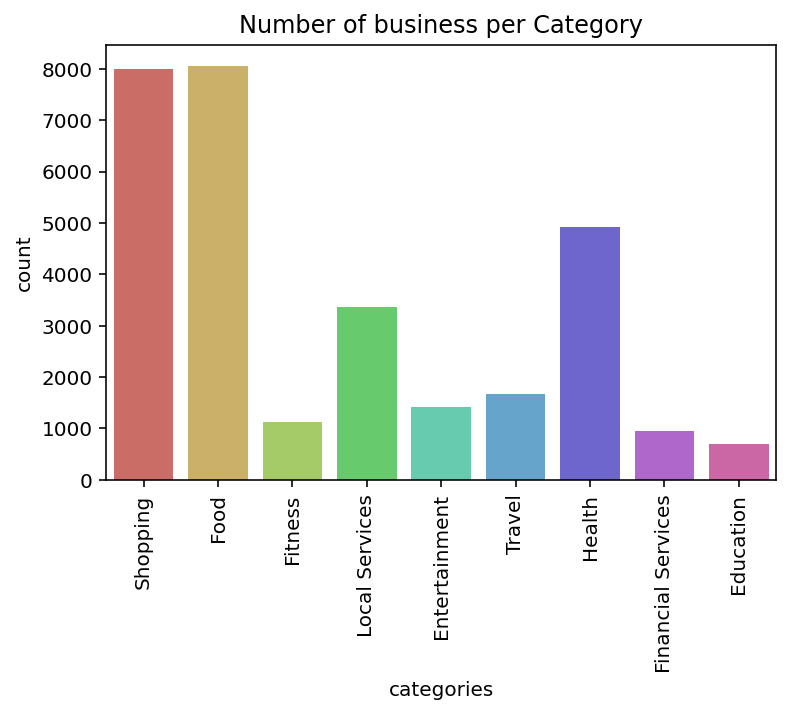

In [13]:
chart = sns.countplot(df['categories'], palette='hls')
plt.title('Number of business per Category')
chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='center', rotation=90);

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30222 entries, 0 to 56061
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      30222 non-null  int64  
 1   business_id     30222 non-null  object 
 2   name            30222 non-null  object 
 3   address         29151 non-null  object 
 4   city            30222 non-null  object 
 5   state           30222 non-null  object 
 6   postal_code     30160 non-null  object 
 7   latitude        30222 non-null  float64
 8   longitude       30222 non-null  float64
 9   stars           30222 non-null  float64
 10  review_count    30222 non-null  int64  
 11  is_open         30222 non-null  int64  
 12  attributes      26532 non-null  object 
 13  categories      30222 non-null  object 
 14  hours           24629 non-null  object 
 15  url             30222 non-null  object 
 16  webpage_text    27327 non-null  object 
 17  1.0             30222 non-null 

In [15]:
folder_path = os.path.join('..', '..', 'data','uncased_L-12_H-768_A-12')
tokenizer = FullTokenizer(vocab_file=os.path.join(folder_path, 'vocab.txt'))

bert_ckpt_file = os.path.join(folder_path, 'bert_model.ckpt')
bert_config_file = os.path.join(folder_path, 'bert_config.json')

tokens_test = tokenizer.tokenize('This is an open-source project for category detection of businesses based on their website contents!')
print(tokens_test)
print(tokenizer.convert_tokens_to_ids(tokens_test))

['this', 'is', 'an', 'open', '-', 'source', 'project', 'for', 'category', 'detection', 'of', 'businesses', 'based', 'on', 'their', 'website', 'contents', '!']
[2023, 2003, 2019, 2330, 1011, 3120, 2622, 2005, 4696, 10788, 1997, 5661, 2241, 2006, 2037, 4037, 8417, 999]


In [16]:
class categoryDetection:    
    def __init__(self, train, test, tokenizer: FullTokenizer, text_colname=None, label_colname=None, max_seq_len=128):
        """  
        """
        self.text_colname = 'webpage_corpus' if text_colname is None else text_colname
        if not self.text_colname in train.columns or not self.text_colname in test.columns:
            print('Error: Please specify a proper column name in the input dataframe as the corpus.')
            return
        
        self.label_colname = 'categories' if label_colname is None else label_colname
        if not self.label_colname in train.columns or not self.label_colname in test.columns:
            print('Error: Please specify a proper column name in the input dataframe as the labels.')
            return
        
        self.classes = train[self.label_colname].unique().tolist()
        self.classes.sort()
        
        train = train.dropna(subset=[self.text_colname])
        test = test.dropna(subset=[self.text_colname])
        
        self.max_seq_len = 0
        self.tokenizer = tokenizer
        (self.train_x, self.train_y), (self.test_x, self.test_y) = map(self._tokanize, [train, test])
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._cut_with_padding, [self.train_x, self.test_x])
    
    def build_model(self, bert_config_file, bert_ckpt_file, dropout=0.6):
        """
        """
        bert = self._load_bert(bert_config_file, bert_ckpt_file)
        input_ = keras.layers.Input(shape=(self.max_seq_len, ), dtype='int64')
        x = bert(input_)
        #get the first embedding from the output of BERT
        x = keras.layers.Lambda(lambda seq: seq[:,0,:])(x)
        
        x = keras.layers.Dropout(dropout)(x)
        x = keras.layers.Dense(300, activation='relu')(x)
        x = keras.layers.Dense(300, activation='relu')(x)
        output_ = keras.layers.Dense(units=len(self.classes), activation='softmax')(x)
        
        model = keras.Model(inputs=input_, outputs=output_)
        model.build(input_shape=(None, self.max_seq_len))
        
        load_stock_weights(bert, bert_ckpt_file)
        
        return model
    
    def _load_bert(self, bert_config_file, bert_ckpt_file):
        try:
            with tf.io.gfile.GFile(bert_config_file, 'r') as gf:
                bert_config = StockBertConfig.from_json_string(gf.read())
                bert_params = map_stock_config_to_params(bert_config)
                bert_params.adapter_size = None
                bert = BertModelLayer.from_params(bert_params, name='bert')
                return bert
        except Exception as e:
            print(e)
    
    def _tokanize(self, df):
        """
        """
        X, y = [], []
        for _, entry in tqdm(df.iterrows()):
            corpus, label = entry[self.text_colname], entry[self.label_colname]
            tokens = self.tokenizer.tokenize(corpus)
            tokens = ['[CLS]'] + tokens + ['[SEP]']
            ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(ids))
            X.append(ids)
            y.append(self.classes.index(label))
        return np.asarray(X), np.asarray(y)
    
    def _cut_with_padding(self, ids):
        """
        """
        X = []
        CLS_id = self.tokenizer.convert_tokens_to_ids(['[CLS]'])
        SEP_id = self.tokenizer.convert_tokens_to_ids(['[SEP]'])
        for token_id in ids:
            # ignore tokens '[CLS]' and '[SEP]' for now
            arr = token_id[1:-1]
            sz = min(len(arr), self.max_seq_len - 2)
            arr = CLS_id + arr[:sz] + SEP_id
            # pad the remaining cells with zero
            arr = arr + [0] * (self.max_seq_len - len(arr))
            X.append(np.asarray(arr))
        return np.asarray(X)

In [17]:
def compile_model(cat:categoryDetection, model, validation_split=0.05, batch_size=64, n_epochs=10, shuffle=True):
    model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')])
    print(model.summary())
    history = model.fit(
        x=cat.train_x,
        y=cat.train_y,
        validation_split=validation_split,
        batch_size=batch_size,
        shuffle=shuffle,
        epochs=n_epochs
    )

In [18]:
split_sz = int(len(df) * 0.8)
train = df[:split_sz]
test = df[split_sz:]

In [19]:
cat = categoryDetection(train, test, tokenizer, max_seq_len=100)

14313it [02:49, 84.49it/s] 
3510it [00:38, 91.34it/s] 


In [20]:
model = cat.build_model(bert_config_file, bert_ckpt_file)

Done loading 196 BERT weights from: ../../data/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f11950bb390> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [21]:
compile_model(cat, model)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 100, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               230700    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 2709  

In [23]:
model.evaluate(cat.test_x, cat.test_y)

110/110 [==============================] - 9s 86ms/step - loss: 2.1166 - acc: 0.2481


[2.116631031036377, 0.2481481432914734]